In [5]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

from keras.layers import TimeDistributed
from keras.layers import Bidirectional

C:\Users\j\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

Opens the csv files for classification 

In [7]:
file = open('stocks_name.txt','r')

Files = []

for line in file:
    line = re.sub('\n', '', line)
    line = line.split('\t')
    if line[1][2:4] == '.A':
        Files.append('csv/BT-A.L.csv')
    elif line[1][2] == '.':
        Files.append('csv/' + line[1] + 'L.csv')
    else:
        Files.append('csv/' + line[1] + '.L.csv')



In [99]:
#"""
Data = open('Data.csv','w+')
Data.write('Date,High,Low,Open,Close,Volume,Adj Close\n')

for file in Files:
    File = open(file, 'r')
    count = 0
    for line in File:
        if count == 0:
            count += 1
        elif count != 0:
            Data.write(line)

    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaled = scaler.fit_transform(values)

Data.close()
#"""

In [23]:
file = open('csv/TSCO.L.csv', 'r')

for line in file:
    count = 0
    company = []

<class 'pandas.core.frame.DataFrame'>
Index: 1264 entries, 2015-01-02 to 2020-01-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1264 non-null   float64
 1   Low        1264 non-null   float64
 2   Open       1264 non-null   float64
 3   Close      1264 non-null   float64
 4   Volume     1264 non-null   float64
 5   Adj Close  1264 non-null   float64
dtypes: float64(6)
memory usage: 69.1+ KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000197B4C2CC88>,
      dtype=object)

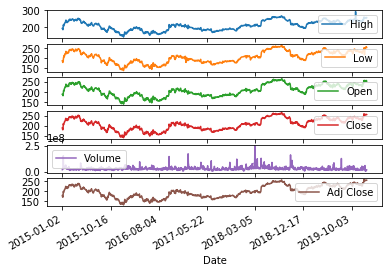

In [8]:
df = pd.read_csv('csv/TSCO.L.csv')
# Sort DataFrame by date
#df = df.sort_values('Date')

df.set_index('Date', inplace=True)
df.info()

df.plot(subplots=True)

In [9]:
df['pred'] = df.Close.shift(-1)

df = df.dropna()
df.describe()

values = df.values
values = values.astype('float32')


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)
scaled.head()


,0,1,2,3,4,5,6
0,0.336156,0.386076,0.388054,0.384252,0.064704,0.367028,0.333858
1,0.333055,0.347912,0.385680,0.333858,0.114553,0.318893,0.311811
2,0.290554,0.319149,0.348892,0.311811,0.099167,0.297834,0.337008
3,0.292508,0.342711,0.332674,0.337008,0.116917,0.321901,0.551575
4,0.474919,0.409102,0.408623,0.551575,0.608425,0.526850,0.511024


In [10]:
def ts(new_data, look_back = 60, pred_col = 1):
    
    t = new_data.copy()
    t['id'] = range(1,len(t)+1)
    t = t.iloc[:-look_back, :]
    t.set_index('id', inplace = True)
    pred_value = new_data.copy()
    pred_value = pred_value.iloc[look_back:, pred_col]
    pred_value.columns = ['Pred']
    pred_value = pd.DataFrame(pred_value)
    
    pred_value['id'] = range(1, len(pred_value)+1)
    pred_value.set_index('id', inplace=True)
    final_df = pd.concat([t, pred_value], axis=1)
    
    return final_df

In [12]:

arr_df = ts(scaled,25,0)

arr_df.fillna(0, inplace=True)

arr_df.columns = ['v0(t-60)','v1(t-60)', 'v2(t-60)', 'v3(t-60)',
                  'v4(t-60)', 'v5(t-60)', 'v6(t-60)', 'v1(t)']

    #df['%change1'] = df['Adj Close'].pct_change(periods=1)*100
    #df['%change2'] = df['Adj Close'].pct_change(periods=2)*100

arr_df.head()

,v0(t-60),v1(t-60),v2(t-60),v3(t-60),v4(t-60),v5(t-60),v6(t-60),v1(t)
id,,,,,,,,
1,0.336156,0.386076,0.388054,0.384252,0.064704,0.367028,0.333858,0.607818
2,0.333055,0.347912,0.385680,0.333858,0.114553,0.318893,0.311811,0.609772
3,0.290554,0.319149,0.348892,0.311811,0.099167,0.297834,0.337008,0.664169
4,0.292508,0.342711,0.332674,0.337008,0.116917,0.321901,0.551575,0.667752
5,0.474919,0.409102,0.408623,0.551575,0.608425,0.526850,0.511024,0.692248


In [13]:
values = arr_df.values
train_sample = int(len(df)*0.8)
train = values[: train_sample, :]
test = values[train_sample:, :]

X_train, y_train = train[:, :-1], train[:, -1:]
X_test, y_test = test[:, :-1], test[:, -1:]

#X_train = X_train.reshape((X_train.shape[0], 1,X_train.shape[1]))
#X_test = X_test.reshape((X_test.shape[0], 1,X_test.shape[1]))
print(len(X_train))

1010


In [14]:
model = Sequential()
model.add(LSTM(180, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(units=90, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1, activation='relu'))

model.compile(loss='mae', optimizer='adam', metrics=['acc'])
model.summary()

IndexError: tuple index out of range

In [19]:
his = model.fit(X_train,y_train, epochs=10, batch_size=64, validation_data=(X_test,y_test),
                shuffle = False)

ValueError: Error when checking input: expected lstm_7_input to have 3 dimensions, but got array with shape (228, 7)

In [33]:

yhat = model.predict(X_test)

X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))
inv_yhat = np.concatenate((yhat,X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

y_test = y_test.reshape((len(y_test),1))
inv_y = np.concatenate((y_test,X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.plot(inv_y,label='actual')
plt.plot(inv_yhat, label = 'Pred')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

mean_squared_error(inv_y, inv_yhat)


AttributeError: 'GaussianNB' object has no attribute 'class_prior_'

In [15]:
df = pd.read_csv('csv/TSCO.L.csv')

df['pred'] = df.Close.shift(-1)

df.set_index('Date', inplace=True)
df.info()
df = df.dropna()
df.describe()

values = df.values
values = values.astype('float32')


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)
scaled.head()



arr_df = ts(scaled,30,0)

arr_df.fillna(0, inplace=True)

arr_df.columns = ['v0(t-60)','v1(t-60)', 'v2(t-60)', 'v3(t-60)',
                  'v4(t-60)', 'v5(t-60)', 'v6(t-60)', 'v1(t)']

arr_df.head()

values = arr_df.values
train_sample = int(len(df)*0.8)
train = values[: train_sample, :]
test = values[train_sample:, :]

X_train, y_train = train[:, :-1], train[:, -1:]
X_test, y_test = test[:, :-1], test[:, -1:]

X_train = X_train.reshape((X_train.shape[0], 1,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1,X_test.shape[1]))
print(len(X_train))

<class 'pandas.core.frame.DataFrame'>
Index: 1264 entries, 2015-01-02 to 2020-01-03
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1264 non-null   float64
 1   Low        1264 non-null   float64
 2   Open       1264 non-null   float64
 3   Close      1264 non-null   float64
 4   Volume     1264 non-null   float64
 5   Adj Close  1264 non-null   float64
 6   pred       1263 non-null   float64
dtypes: float64(7)
memory usage: 79.0+ KB
1010


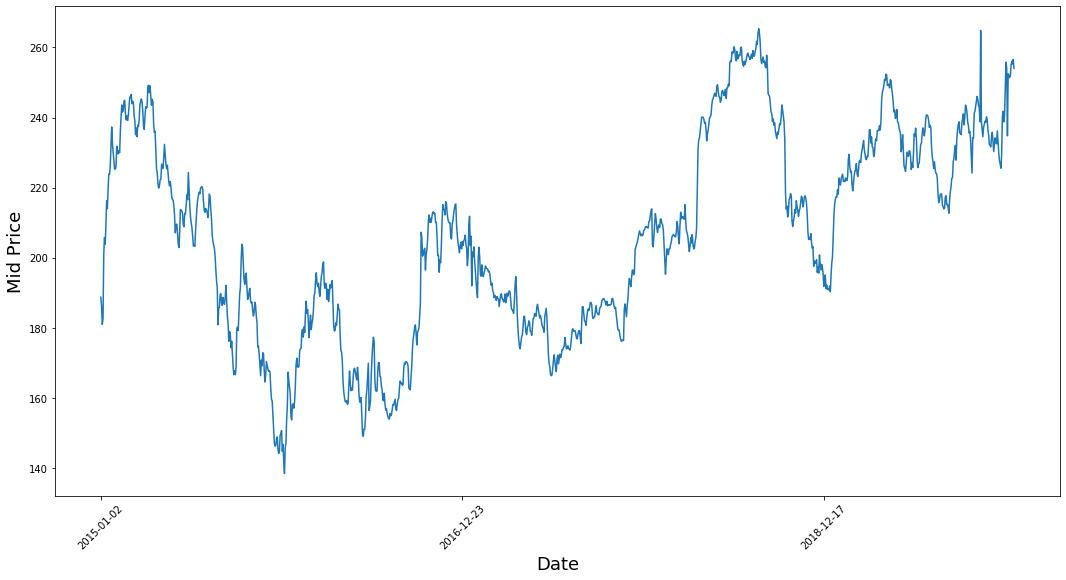

In [16]:
df = pd.read_csv('csv/TSCO.L.csv')
# Sort DataFrame by date
df = df.sort_values('Date')

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


MSE error for standard averaging: 0.00157


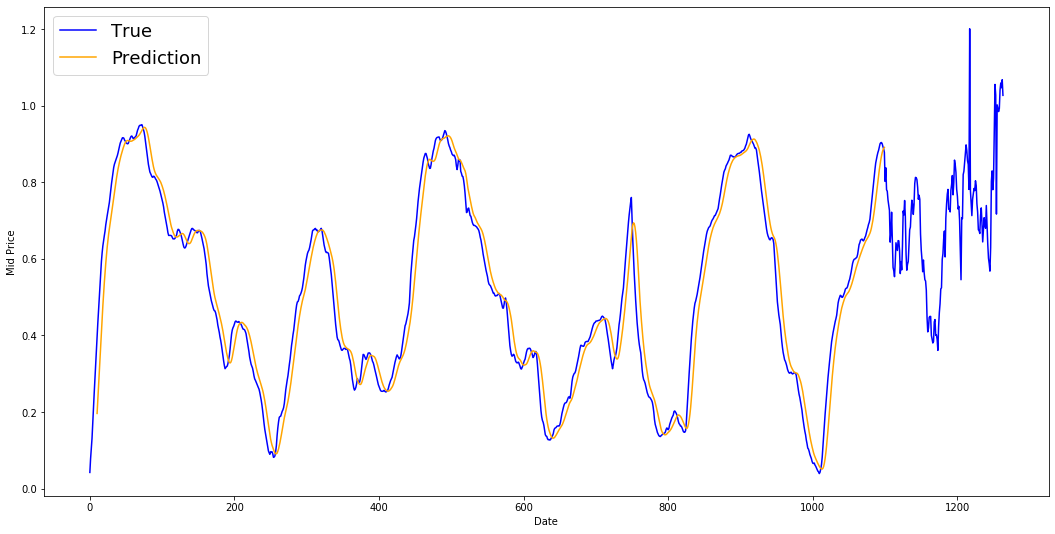

In [17]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

#NEED to incoperate more data
train_data = mid_prices[:1100]
test_data = mid_prices[1100:]

# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Train the Scaler with training data and smooth data
smoothing_window_size = 250 #Increase this
for di in range(0,1000,smoothing_window_size): #Increase 1000 to 10000
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1100):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()